In [10]:
import os
import gc
import sys
import numpy as np
import random
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm

import matplotlib.pyplot as plt
import IPython.display as ipd

In [11]:
if torch.cuda.is_available():
            print('CUDA available')
            print(torch.cuda.get_device_name(0))
            print('Memory Usage:')
            print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
            print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
            
else:
    print('WARNING: CUDA is not available')

CUDA available
NVIDIA GeForce RTX 3060 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    4.2 GB


In [12]:
# Global Vars
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
path = "./Data/genres_original/"
csv_3 = "./Data/features_3_sec.csv"
csv_30 = "./Data/features_30_sec.csv"

audio_paths = [f for f in Path(path).glob('*\*.wav')]

batch_size = 32
num_workers = 0
epochs = 100

sample_rate = 44100
n_mels = 128

melkwargs = {
    'hop_length' : 300,
    'f_min' : 20,
    'f_max' : sample_rate // 2,
    'n_mels' : n_mels,
    'n_fft' : n_mels * 20}


validation_split = .2
random_seed= 42

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 1) # set default size of plots

print(audio_paths[:10])

[WindowsPath('Data/genres_original/blues/blues.00000.wav'), WindowsPath('Data/genres_original/blues/blues.00001.wav'), WindowsPath('Data/genres_original/blues/blues.00002.wav'), WindowsPath('Data/genres_original/blues/blues.00003.wav'), WindowsPath('Data/genres_original/blues/blues.00004.wav'), WindowsPath('Data/genres_original/blues/blues.00005.wav'), WindowsPath('Data/genres_original/blues/blues.00006.wav'), WindowsPath('Data/genres_original/blues/blues.00007.wav'), WindowsPath('Data/genres_original/blues/blues.00008.wav'), WindowsPath('Data/genres_original/blues/blues.00009.wav')]


In [13]:
# Local Dataset
# data = DataLoader(path, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

# get class mapping
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

classes, class_dict = find_classes(path)

print(classes, list(class_dict.items())[:10])

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock'] [('blues', 0), ('classical', 1), ('country', 2), ('disco', 3), ('hiphop', 4), ('jazz', 5), ('metal', 6), ('pop', 7), ('reggae', 8), ('rock', 9)]


In [14]:
# Dataset
# Data in the Models folder containts 100 audio samples per class
# This function splits audio into 80/20 train and test splits
class GTZAN(Dataset):
        def __init__(self, paths: list, transform=None):
                self.paths = paths
                self.transform = transform
        
        def __len__(self):
                return len(self.paths)

        def __getitem__(self, index):              
                signal, sr = torchaudio.load(self.paths[index])
                if self.transform:
                        signal = self.transform(signal)
                label = self.paths[index].__str__().split('\\')[2]
                return signal, label        

def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        tensors += [waveform]
        targets += [torch.tensor(class_dict[label])]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets      


#############################################################################################################################         

test_paths = []
train_paths = []
for genre in classes:
        # get list of audio files in that genre
        samples = [f for f in Path(path).glob(f'*\{genre}.*.wav')]

        # Split list 80:20
        trainlist = samples[:80] # first 80
        testlist = samples[80:] 
        test_paths.extend(testlist)
        train_paths.extend(trainlist)

transform = nn.Sequential(
        torchaudio.transforms.Resample(sample_rate),
        torchaudio.transforms.MFCC(sample_rate, n_mfcc=80, melkwargs=melkwargs)
).to(device)

train_set = GTZAN(train_paths)
test_set = GTZAN(test_paths)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers, collate_fn=collate_fn)


Shape of waveform: torch.Size([1, 661794])


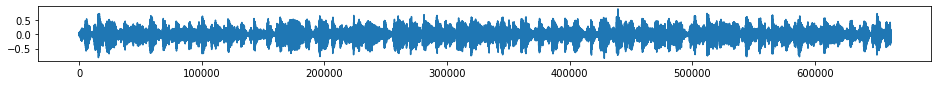

In [15]:
# visualise one audio sample
sample = train_set[0][0]
print("Shape of waveform: {}".format(train_set[0][0].size()))
plt.plot(sample.t().numpy())

In [16]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=10, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [17]:
input_size = train_set[0][0].shape[0]
model = M5(n_input=input_size, n_output=len(classes))
model.to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after n epochs by a factor of gamma

n = count_parameters(model)
print("Number of parameters: %s" % n)


M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=10, bias=True)
)
Numbe

In [18]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        # data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch, best):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        # data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)
        acc = round(100. * correct / len(test_loader.dataset), 3)

        if acc > best[1]:
            best = (epoch, acc)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({acc}%)\n")

In [19]:
log_interval = 100
best = (0, 0)

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
with tqdm(total=epochs) as pbar:
    for epoch in range(1, epochs + 1):
        train(model, epoch, log_interval)
        test(model, epoch, best)
        scheduler.step()

  0%|          | 0.09375/100 [00:00<08:22,  5.03s/it]

Train Epoch: 1 [0/800 (0%)]	Loss: 2.546505


  1%|          | 1.03125/100 [00:03<04:34,  2.77s/it]


Test Epoch: 1	Accuracy: 36/200 (18.0%)

Train Epoch: 2 [0/800 (0%)]	Loss: 1.417257


  2%|▏         | 2.0625/100 [00:06<04:20,  2.66s/it] 


Test Epoch: 2	Accuracy: 68/200 (34.0%)

Train Epoch: 3 [0/800 (0%)]	Loss: 1.484086


  3%|▎         | 3.0625/100 [00:10<04:17,  2.66s/it] 


Test Epoch: 3	Accuracy: 61/200 (30.5%)

Train Epoch: 4 [0/800 (0%)]	Loss: 1.482430


  4%|▍         | 4.0625/100 [00:13<04:12,  2.63s/it] 


Test Epoch: 4	Accuracy: 67/200 (33.5%)

Train Epoch: 5 [0/800 (0%)]	Loss: 1.498589


  5%|▌         | 5.0625/100 [00:16<04:04,  2.57s/it] 


Test Epoch: 5	Accuracy: 40/200 (20.0%)

Train Epoch: 6 [0/800 (0%)]	Loss: 1.145868


  6%|▌         | 6.0625/100 [00:19<04:14,  2.71s/it] 


Test Epoch: 6	Accuracy: 41/200 (20.5%)

Train Epoch: 7 [0/800 (0%)]	Loss: 0.923337


  7%|▋         | 7.0625/100 [00:22<04:13,  2.73s/it] 


Test Epoch: 7	Accuracy: 79/200 (39.5%)

Train Epoch: 8 [0/800 (0%)]	Loss: 1.036500


  8%|▊         | 8.0625/100 [00:26<04:00,  2.62s/it] 


Test Epoch: 8	Accuracy: 79/200 (39.5%)

Train Epoch: 9 [0/800 (0%)]	Loss: 1.329917


  9%|▉         | 9.0625/100 [00:29<04:05,  2.70s/it] 


Test Epoch: 9	Accuracy: 73/200 (36.5%)

Train Epoch: 10 [0/800 (0%)]	Loss: 0.916573


 10%|█         | 10.03125/100 [00:32<03:56,  2.63s/it]


Test Epoch: 10	Accuracy: 97/200 (48.5%)

Train Epoch: 11 [0/800 (0%)]	Loss: 0.872585


 11%|█         | 11.0625/100 [00:35<04:07,  2.79s/it] 


Test Epoch: 11	Accuracy: 84/200 (42.0%)

Train Epoch: 12 [0/800 (0%)]	Loss: 0.977605


 12%|█▏        | 12.0625/100 [00:38<04:05,  2.79s/it] 


Test Epoch: 12	Accuracy: 101/200 (50.5%)

Train Epoch: 13 [0/800 (0%)]	Loss: 0.730893


 13%|█▎        | 13.03125/100 [00:41<03:49,  2.63s/it]


Test Epoch: 13	Accuracy: 83/200 (41.5%)

Train Epoch: 14 [0/800 (0%)]	Loss: 0.674864


 14%|█▍        | 14.03125/100 [00:44<03:40,  2.56s/it]


Test Epoch: 14	Accuracy: 92/200 (46.0%)

Train Epoch: 15 [0/800 (0%)]	Loss: 0.940301


 15%|█▌        | 15.03125/100 [00:48<03:49,  2.70s/it]


Test Epoch: 15	Accuracy: 86/200 (43.0%)

Train Epoch: 16 [0/800 (0%)]	Loss: 0.679740


 16%|█▌        | 16.0625/100 [00:51<03:42,  2.66s/it] 


Test Epoch: 16	Accuracy: 61/200 (30.5%)

Train Epoch: 17 [0/800 (0%)]	Loss: 1.317427


 17%|█▋        | 17.0625/100 [00:54<03:45,  2.72s/it] 


Test Epoch: 17	Accuracy: 97/200 (48.5%)

Train Epoch: 18 [0/800 (0%)]	Loss: 0.873616


 18%|█▊        | 18.0625/100 [00:58<03:43,  2.72s/it] 


Test Epoch: 18	Accuracy: 90/200 (45.0%)

Train Epoch: 19 [0/800 (0%)]	Loss: 0.504228


 19%|█▉        | 19.0625/100 [01:01<03:37,  2.69s/it] 


Test Epoch: 19	Accuracy: 79/200 (39.5%)

Train Epoch: 20 [0/800 (0%)]	Loss: 0.706785


 20%|██        | 20.0625/100 [01:04<03:39,  2.75s/it] 


Test Epoch: 20	Accuracy: 96/200 (48.0%)

Train Epoch: 21 [0/800 (0%)]	Loss: 0.658842


 21%|██        | 21.0625/100 [01:07<03:26,  2.62s/it] 


Test Epoch: 21	Accuracy: 108/200 (54.0%)

Train Epoch: 22 [0/800 (0%)]	Loss: 0.710027


 22%|██▏       | 22.0625/100 [01:11<03:23,  2.61s/it] 


Test Epoch: 22	Accuracy: 117/200 (58.5%)

Train Epoch: 23 [0/800 (0%)]	Loss: 1.031358


 23%|██▎       | 23.0625/100 [01:14<03:21,  2.62s/it] 


Test Epoch: 23	Accuracy: 118/200 (59.0%)

Train Epoch: 24 [0/800 (0%)]	Loss: 0.527656


 24%|██▍       | 24.0625/100 [01:17<03:23,  2.68s/it] 


Test Epoch: 24	Accuracy: 121/200 (60.5%)

Train Epoch: 25 [0/800 (0%)]	Loss: 0.517122


 25%|██▌       | 25.0625/100 [01:20<03:19,  2.67s/it] 


Test Epoch: 25	Accuracy: 119/200 (59.5%)

Train Epoch: 26 [0/800 (0%)]	Loss: 0.369001


 26%|██▌       | 26.0625/100 [01:24<03:14,  2.63s/it] 


Test Epoch: 26	Accuracy: 120/200 (60.0%)

Train Epoch: 27 [0/800 (0%)]	Loss: 0.732258


 27%|██▋       | 27.0625/100 [01:27<03:13,  2.66s/it] 


Test Epoch: 27	Accuracy: 118/200 (59.0%)

Train Epoch: 28 [0/800 (0%)]	Loss: 0.464722


 28%|██▊       | 28.0625/100 [01:30<03:07,  2.61s/it] 


Test Epoch: 28	Accuracy: 119/200 (59.5%)

Train Epoch: 29 [0/800 (0%)]	Loss: 0.385584


 29%|██▉       | 29.0625/100 [01:33<03:05,  2.62s/it] 


Test Epoch: 29	Accuracy: 125/200 (62.5%)

Train Epoch: 30 [0/800 (0%)]	Loss: 0.532631


 30%|███       | 30.0625/100 [01:36<03:06,  2.66s/it] 


Test Epoch: 30	Accuracy: 121/200 (60.5%)

Train Epoch: 31 [0/800 (0%)]	Loss: 0.725054


 31%|███       | 31.0625/100 [01:40<02:59,  2.61s/it] 


Test Epoch: 31	Accuracy: 112/200 (56.0%)

Train Epoch: 32 [0/800 (0%)]	Loss: 0.528147


 32%|███▏      | 32.0625/100 [01:43<02:55,  2.58s/it] 


Test Epoch: 32	Accuracy: 124/200 (62.0%)

Train Epoch: 33 [0/800 (0%)]	Loss: 0.509850


 33%|███▎      | 33.03125/100 [01:46<02:51,  2.56s/it]


Test Epoch: 33	Accuracy: 113/200 (56.5%)

Train Epoch: 34 [0/800 (0%)]	Loss: 0.471375


 34%|███▍      | 34.0625/100 [01:49<02:53,  2.63s/it] 


Test Epoch: 34	Accuracy: 119/200 (59.5%)

Train Epoch: 35 [0/800 (0%)]	Loss: 0.497925


 35%|███▌      | 35.0625/100 [01:52<02:51,  2.65s/it] 


Test Epoch: 35	Accuracy: 122/200 (61.0%)

Train Epoch: 36 [0/800 (0%)]	Loss: 0.513230


 36%|███▌      | 36.0625/100 [01:55<02:51,  2.69s/it] 


Test Epoch: 36	Accuracy: 116/200 (58.0%)

Train Epoch: 37 [0/800 (0%)]	Loss: 0.745394


 37%|███▋      | 37.0625/100 [01:59<02:45,  2.63s/it] 


Test Epoch: 37	Accuracy: 122/200 (61.0%)

Train Epoch: 38 [0/800 (0%)]	Loss: 0.362084


 38%|███▊      | 38.0625/100 [02:02<02:41,  2.61s/it] 


Test Epoch: 38	Accuracy: 123/200 (61.5%)

Train Epoch: 39 [0/800 (0%)]	Loss: 0.438037


 39%|███▉      | 39.0625/100 [02:05<02:38,  2.61s/it] 


Test Epoch: 39	Accuracy: 120/200 (60.0%)

Train Epoch: 40 [0/800 (0%)]	Loss: 0.616230


 40%|████      | 40.0625/100 [02:08<02:40,  2.68s/it] 


Test Epoch: 40	Accuracy: 125/200 (62.5%)

Train Epoch: 41 [0/800 (0%)]	Loss: 0.315777


 41%|████      | 41.0625/100 [02:11<02:36,  2.66s/it] 


Test Epoch: 41	Accuracy: 125/200 (62.5%)

Train Epoch: 42 [0/800 (0%)]	Loss: 0.372748


 42%|████▏     | 42.0/100 [02:14<02:37,  2.71s/it]    


Test Epoch: 42	Accuracy: 123/200 (61.5%)

Train Epoch: 43 [0/800 (0%)]	Loss: 0.589549


 43%|████▎     | 43.0625/100 [02:18<02:28,  2.61s/it] 


Test Epoch: 43	Accuracy: 124/200 (62.0%)

Train Epoch: 44 [0/800 (0%)]	Loss: 0.476387


 44%|████▍     | 44.0/100 [02:21<02:17,  2.46s/it]    


Test Epoch: 44	Accuracy: 126/200 (63.0%)



 44%|████▍     | 44.0625/100 [02:21<03:08,  3.37s/it]

Train Epoch: 45 [0/800 (0%)]	Loss: 1.022158


 45%|████▌     | 45.0625/100 [02:24<02:25,  2.65s/it] 


Test Epoch: 45	Accuracy: 123/200 (61.5%)

Train Epoch: 46 [0/800 (0%)]	Loss: 0.607451


 46%|████▌     | 46.0625/100 [02:27<02:20,  2.60s/it] 


Test Epoch: 46	Accuracy: 124/200 (62.0%)

Train Epoch: 47 [0/800 (0%)]	Loss: 0.585798


 47%|████▋     | 47.03125/100 [02:30<02:17,  2.60s/it]


Test Epoch: 47	Accuracy: 127/200 (63.5%)

Train Epoch: 48 [0/800 (0%)]	Loss: 0.452249


 48%|████▊     | 48.03125/100 [02:34<02:15,  2.61s/it]


Test Epoch: 48	Accuracy: 127/200 (63.5%)

Train Epoch: 49 [0/800 (0%)]	Loss: 0.575950


 49%|████▉     | 49.0625/100 [02:37<02:11,  2.58s/it] 


Test Epoch: 49	Accuracy: 128/200 (64.0%)

Train Epoch: 50 [0/800 (0%)]	Loss: 0.520797


 50%|█████     | 50.0625/100 [02:40<02:11,  2.63s/it] 


Test Epoch: 50	Accuracy: 126/200 (63.0%)

Train Epoch: 51 [0/800 (0%)]	Loss: 0.259186


 51%|█████     | 51.0625/100 [02:43<02:10,  2.67s/it] 


Test Epoch: 51	Accuracy: 126/200 (63.0%)

Train Epoch: 52 [0/800 (0%)]	Loss: 0.687434


 52%|█████▏    | 52.0625/100 [02:46<02:07,  2.65s/it] 


Test Epoch: 52	Accuracy: 125/200 (62.5%)

Train Epoch: 53 [0/800 (0%)]	Loss: 0.679264


 53%|█████▎    | 53.03125/100 [02:50<02:03,  2.62s/it]


Test Epoch: 53	Accuracy: 125/200 (62.5%)

Train Epoch: 54 [0/800 (0%)]	Loss: 0.343316


 54%|█████▍    | 54.0625/100 [02:53<02:00,  2.61s/it] 


Test Epoch: 54	Accuracy: 125/200 (62.5%)

Train Epoch: 55 [0/800 (0%)]	Loss: 0.472493


 55%|█████▌    | 55.0625/100 [02:56<01:56,  2.59s/it] 


Test Epoch: 55	Accuracy: 131/200 (65.5%)

Train Epoch: 56 [0/800 (0%)]	Loss: 0.835084


 56%|█████▌    | 56.0625/100 [02:59<01:57,  2.68s/it] 


Test Epoch: 56	Accuracy: 121/200 (60.5%)

Train Epoch: 57 [0/800 (0%)]	Loss: 0.452737


 57%|█████▋    | 57.0625/100 [03:02<01:57,  2.73s/it] 


Test Epoch: 57	Accuracy: 121/200 (60.5%)

Train Epoch: 58 [0/800 (0%)]	Loss: 0.480535


 58%|█████▊    | 58.0625/100 [03:06<01:48,  2.60s/it] 


Test Epoch: 58	Accuracy: 124/200 (62.0%)

Train Epoch: 59 [0/800 (0%)]	Loss: 0.432048


 59%|█████▉    | 59.03125/100 [03:09<01:47,  2.63s/it]


Test Epoch: 59	Accuracy: 129/200 (64.5%)

Train Epoch: 60 [0/800 (0%)]	Loss: 0.325498


 60%|██████    | 60.0625/100 [03:12<01:44,  2.62s/it] 


Test Epoch: 60	Accuracy: 125/200 (62.5%)

Train Epoch: 61 [0/800 (0%)]	Loss: 0.366749


 61%|██████    | 61.0625/100 [03:15<01:45,  2.71s/it] 


Test Epoch: 61	Accuracy: 123/200 (61.5%)

Train Epoch: 62 [0/800 (0%)]	Loss: 0.469816


 62%|██████▏   | 62.0625/100 [03:18<01:40,  2.66s/it] 


Test Epoch: 62	Accuracy: 120/200 (60.0%)

Train Epoch: 63 [0/800 (0%)]	Loss: 0.309244


 63%|██████▎   | 63.0625/100 [03:22<01:39,  2.70s/it] 


Test Epoch: 63	Accuracy: 126/200 (63.0%)

Train Epoch: 64 [0/800 (0%)]	Loss: 0.445155


 64%|██████▍   | 64.0625/100 [03:25<01:31,  2.55s/it] 


Test Epoch: 64	Accuracy: 123/200 (61.5%)

Train Epoch: 65 [0/800 (0%)]	Loss: 0.418067


 65%|██████▌   | 65.0625/100 [03:28<01:30,  2.59s/it] 


Test Epoch: 65	Accuracy: 126/200 (63.0%)

Train Epoch: 66 [0/800 (0%)]	Loss: 0.441550


 66%|██████▌   | 66.0625/100 [03:31<01:30,  2.67s/it] 


Test Epoch: 66	Accuracy: 127/200 (63.5%)

Train Epoch: 67 [0/800 (0%)]	Loss: 0.294537


 67%|██████▋   | 67.0625/100 [03:34<01:26,  2.62s/it] 


Test Epoch: 67	Accuracy: 124/200 (62.0%)

Train Epoch: 68 [0/800 (0%)]	Loss: 0.274860


 68%|██████▊   | 68.0625/100 [03:37<01:23,  2.63s/it] 


Test Epoch: 68	Accuracy: 122/200 (61.0%)

Train Epoch: 69 [0/800 (0%)]	Loss: 0.436388


 69%|██████▉   | 69.03125/100 [03:40<01:21,  2.65s/it]


Test Epoch: 69	Accuracy: 125/200 (62.5%)

Train Epoch: 70 [0/800 (0%)]	Loss: 0.598679


 70%|███████   | 70.03125/100 [03:44<01:17,  2.57s/it]


Test Epoch: 70	Accuracy: 123/200 (61.5%)

Train Epoch: 71 [0/800 (0%)]	Loss: 0.394523


 71%|███████   | 71.0625/100 [03:47<01:14,  2.58s/it] 


Test Epoch: 71	Accuracy: 126/200 (63.0%)

Train Epoch: 72 [0/800 (0%)]	Loss: 0.489288


 72%|███████▏  | 72.0625/100 [03:50<01:15,  2.70s/it] 


Test Epoch: 72	Accuracy: 124/200 (62.0%)

Train Epoch: 73 [0/800 (0%)]	Loss: 0.734184


 73%|███████▎  | 73.0625/100 [03:53<01:14,  2.77s/it] 


Test Epoch: 73	Accuracy: 122/200 (61.0%)

Train Epoch: 74 [0/800 (0%)]	Loss: 0.503725


 74%|███████▍  | 74.0625/100 [03:56<01:09,  2.67s/it] 


Test Epoch: 74	Accuracy: 125/200 (62.5%)

Train Epoch: 75 [0/800 (0%)]	Loss: 0.316860


 75%|███████▌  | 75.03125/100 [04:00<01:05,  2.62s/it]


Test Epoch: 75	Accuracy: 122/200 (61.0%)

Train Epoch: 76 [0/800 (0%)]	Loss: 0.421117


 76%|███████▌  | 76.0625/100 [04:03<01:02,  2.62s/it] 


Test Epoch: 76	Accuracy: 126/200 (63.0%)

Train Epoch: 77 [0/800 (0%)]	Loss: 0.447005


 77%|███████▋  | 77.0/100 [04:06<00:55,  2.43s/it]    


Test Epoch: 77	Accuracy: 125/200 (62.5%)



 77%|███████▋  | 77.0625/100 [04:06<01:15,  3.28s/it]

Train Epoch: 78 [0/800 (0%)]	Loss: 1.246581


 78%|███████▊  | 78.0625/100 [04:09<00:57,  2.63s/it] 


Test Epoch: 78	Accuracy: 126/200 (63.0%)

Train Epoch: 79 [0/800 (0%)]	Loss: 0.575854


 79%|███████▉  | 79.0625/100 [04:12<00:55,  2.64s/it] 


Test Epoch: 79	Accuracy: 123/200 (61.5%)

Train Epoch: 80 [0/800 (0%)]	Loss: 0.769502


 80%|████████  | 80.0625/100 [04:15<00:52,  2.66s/it] 


Test Epoch: 80	Accuracy: 123/200 (61.5%)

Train Epoch: 81 [0/800 (0%)]	Loss: 0.415610


 81%|████████  | 81.03125/100 [04:19<00:49,  2.59s/it]


Test Epoch: 81	Accuracy: 127/200 (63.5%)

Train Epoch: 82 [0/800 (0%)]	Loss: 0.431541


 82%|████████▏ | 82.0625/100 [04:22<00:47,  2.64s/it] 


Test Epoch: 82	Accuracy: 122/200 (61.0%)

Train Epoch: 83 [0/800 (0%)]	Loss: 0.748280


 83%|████████▎ | 83.0625/100 [04:25<00:45,  2.70s/it] 


Test Epoch: 83	Accuracy: 119/200 (59.5%)

Train Epoch: 84 [0/800 (0%)]	Loss: 0.366604


 84%|████████▍ | 84.0625/100 [04:28<00:42,  2.69s/it] 


Test Epoch: 84	Accuracy: 120/200 (60.0%)

Train Epoch: 85 [0/800 (0%)]	Loss: 0.622224


 85%|████████▌ | 85.0625/100 [04:31<00:41,  2.75s/it] 


Test Epoch: 85	Accuracy: 121/200 (60.5%)

Train Epoch: 86 [0/800 (0%)]	Loss: 0.345367


 86%|████████▌ | 86.0625/100 [04:34<00:37,  2.69s/it] 


Test Epoch: 86	Accuracy: 121/200 (60.5%)

Train Epoch: 87 [0/800 (0%)]	Loss: 0.391451


 87%|████████▋ | 87.0625/100 [04:38<00:34,  2.69s/it] 


Test Epoch: 87	Accuracy: 122/200 (61.0%)

Train Epoch: 88 [0/800 (0%)]	Loss: 0.481775


 88%|████████▊ | 88.0625/100 [04:41<00:30,  2.59s/it] 


Test Epoch: 88	Accuracy: 124/200 (62.0%)

Train Epoch: 89 [0/800 (0%)]	Loss: 0.580766


 89%|████████▉ | 89.0625/100 [04:44<00:29,  2.68s/it] 


Test Epoch: 89	Accuracy: 125/200 (62.5%)

Train Epoch: 90 [0/800 (0%)]	Loss: 0.555197


 90%|█████████ | 90.0625/100 [04:47<00:26,  2.63s/it] 


Test Epoch: 90	Accuracy: 124/200 (62.0%)

Train Epoch: 91 [0/800 (0%)]	Loss: 0.743696


 91%|█████████ | 91.0625/100 [04:50<00:24,  2.79s/it] 


Test Epoch: 91	Accuracy: 121/200 (60.5%)

Train Epoch: 92 [0/800 (0%)]	Loss: 0.456065


 92%|█████████▏| 92.0625/100 [04:54<00:21,  2.67s/it]


Test Epoch: 92	Accuracy: 122/200 (61.0%)

Train Epoch: 93 [0/800 (0%)]	Loss: 0.423694


 93%|█████████▎| 93.0625/100 [04:57<00:17,  2.59s/it] 


Test Epoch: 93	Accuracy: 125/200 (62.5%)

Train Epoch: 94 [0/800 (0%)]	Loss: 0.427654


 94%|█████████▍| 94.0625/100 [05:00<00:15,  2.57s/it] 


Test Epoch: 94	Accuracy: 124/200 (62.0%)

Train Epoch: 95 [0/800 (0%)]	Loss: 0.391692


 95%|█████████▌| 95.0625/100 [05:03<00:12,  2.62s/it] 


Test Epoch: 95	Accuracy: 126/200 (63.0%)

Train Epoch: 96 [0/800 (0%)]	Loss: 0.371721


 96%|█████████▌| 96.0625/100 [05:06<00:10,  2.64s/it] 


Test Epoch: 96	Accuracy: 124/200 (62.0%)

Train Epoch: 97 [0/800 (0%)]	Loss: 0.581852


 97%|█████████▋| 97.0/100 [05:09<00:07,  2.62s/it]    


Test Epoch: 97	Accuracy: 124/200 (62.0%)



 97%|█████████▋| 97.0625/100 [05:10<00:09,  3.35s/it]

Train Epoch: 98 [0/800 (0%)]	Loss: 1.236073


 98%|█████████▊| 98.0625/100 [05:13<00:05,  2.64s/it]


Test Epoch: 98	Accuracy: 128/200 (64.0%)

Train Epoch: 99 [0/800 (0%)]	Loss: 0.502887


 99%|█████████▉| 99.0625/100 [05:16<00:02,  2.56s/it] 


Test Epoch: 99	Accuracy: 127/200 (63.5%)

Train Epoch: 100 [0/800 (0%)]	Loss: 0.300920


100%|██████████| 100.0/100 [05:19<00:00,  3.19s/it]   


Test Epoch: 100	Accuracy: 125/200 (62.5%)



Text(0.5, 1.0, 'training loss')

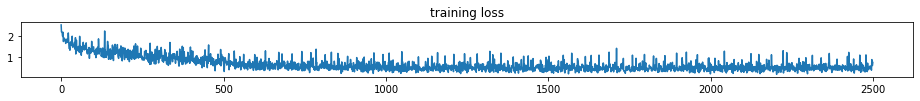

In [20]:

plt.plot(losses)
plt.title("training loss")